In [ ]:
# Install necessary libraries for Google Colab
!pip install torch torchvision
!pip install segmentation-models-pytorch
!pip install monai
!pip install torchmetrics
!pip install transformers
!pip install numpy  # Usually pre-installed in Colab
!pip install matplotlib  # Usually pre-installed in Colab
!pip install opencv-python-headless
!pip install nibabel
!pip install tqdm  # Usually pre-installed in Colab


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/Stroke_Segmentation


/content/drive/My Drive/Stroke_Segmentation


In [ ]:
!ls


custom_model.py   main.ipynb  output	     __pycache__  test_set.pkl
kfold_splits.pkl  model.py    preprocess.py  README.md	  training.ipynb


In [ ]:
import os
import segmentation_models_pytorch as smp
from monai.data import DataLoader, Dataset
import torch
from torchmetrics import JaccardIndex
from tqdm import tqdm
from custom_model import CustomModel
from transformers import SegformerConfig, SegformerForSemanticSegmentation
import numpy as np
import pickle

In [ ]:
if os.path.exists("kfold_splits.pkl"):
    with open('kfold_splits.pkl', 'rb') as file:
    # Load train and validation data
        folds = pickle.load(file)
else:
    from preprocess import folds

if os.path.exists("test_set.pkl"):
    with open('test_set.pkl', 'rb') as file:
    # Load test data
        test_set = pickle.load(file)
else:
    from preprocess import test_set

In [ ]:
os.makedirs('./output', exist_ok=True)
root_dir = './output'

In [ ]:
gpu = "cpu"
loss = "Jaccard"
model_type = "segformer"

In [ ]:
# if gpu == "cuda":
#     device = torch.device("cuda:0")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if loss == "Dice":
    loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)
elif loss == "Jaccard":
    loss_function = smp.losses.JaccardLoss(mode="binary", from_logits=False)

metric = JaccardIndex(task="binary").to(device)

In [ ]:
if model_type == "resnet":
    # Create the UNet model with the specified backbone
    model = smp.Unet(
        encoder_name="resnet34",
        in_channels=3,
        classes=1,
        activation="sigmoid",
        encoder_weights=None
    ).to(device)
elif model_type == "unet":
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True).to(device)
elif model_type == "segformer":
    config = SegformerConfig(num_labels=1)
    model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512", num_labels=1, ignore_mismatched_sizes=True).to(device)
elif model_type == "custom":
    model = CustomModel(
        channels = [64, 128, 256, 512],
        scale = [4, 2, 2, 2],
        num_blocks = [2, 2, 2, 2],
        num_heads = [2, 4, 8, 16],
        mlp_hidden = [256, 512, 1024, 2048],
        dropout = 0.0,                     # change to dropout rate=0.2
        decoder_hidden = 256,
        attention=True
    ).to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# x = torch.randn(1, 3, 128, 128)
# model = CustomModel(
#         channels = [64, 128, 256, 512],
#         scale = [4, 2, 2, 2],
#         num_blocks = [2, 2, 2, 2],
#         num_heads = [2, 4, 8, 16],
#         mlp_hidden = [256, 512, 1024, 2048],
#         dropout = 0.0,                     # change to dropout rate=0.2
#         decoder_hidden = 256,
#     )
# l =model.encoder(x)
# for i in range(len(l)):
#     print(l[i].shape)
# l.reverse()
# model.decoder(l).shape

In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of parameters: {total_params}")
    print(f"Number of trainable parameters: {trainable_params}")
count_parameters(model)

Total number of parameters: 3714401
Number of trainable parameters: 3714401


In [ ]:
model.parameters

<bound method Module.parameters of SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
      )
      (block): ModuleList(
        (0): ModuleList(
          (0): SegformerLayer(
            (layer_norm_1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (attention): SegformerAttention(
              (self): SegformerEfficientSelfAttention(
                (query): Linear(in_features=32, out_features=32, bias=True)
                (key): Linear(in_features=32, out_features=32, bias=True)
                (value): Linear(in_features=32, out_features=32, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (sr): Conv2d(32, 32, kernel_size=(8, 8), stride=(8, 8))
                (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
              )
              (output): SegformerSelfOutput(
                (dense): Linear(in_features=32, out_features=32, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (drop_path): Identity()
            (layer_norm_2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (mlp): SegformerMixFFN(
              (dense1): Linear(in_features=32, out_features=128, bias=True)
              (dwconv): SegformerDWConv(
                (dwconv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
              )
              (intermediate_act_fn): GELUActivation()
              (dense2): Linear(in_features=128, out_features=32, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (1): SegformerLayer(
            (layer_norm_1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (attention): SegformerAttention(
              (self): SegformerEfficientSelfAttention(
                (query): Linear(in_features=32, out_features=32, bias=True)
                (key): Linear(in_features=32, out_features=32, bias=True)
                (value): Linear(in_features=32, out_features=32, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (sr): Conv2d(32, 32, kernel_size=(8, 8), stride=(8, 8))
                (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
              )
              (output): SegformerSelfOutput(
                (dense): Linear(in_features=32, out_features=32, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (drop_path): SegformerDropPath(p=0.014285714365541935)
            (layer_norm_2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (mlp): SegformerMixFFN(
              (dense1): Linear(in_features=32, out_features=128, bias=True)
              (dwconv): SegformerDWConv(
                (dwconv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
              )
              (intermediate_act_fn): GELUActivation()
              (dense2): Linear(in_features=128, out_features=32, bias

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [ ]:
os.makedirs(os.path.join(root_dir, model_type), exist_ok=True)
out_dir = os.path.join(root_dir, model_type)

In [ ]:
out_dir

'./output/segformer'

In [ ]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []


num_CV = 5
max_epochs = 100
epoch_per_CV = max_epochs // num_CV

for i in range(num_CV):

    print("-" * 10)
    print(f"Fold {i}")
    train_ds = folds[i]["train"]
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
    val_ds = folds[i]["val"]
    val_loader = DataLoader(val_ds, batch_size=8, num_workers=4)

    if i < num_CV - 1:
        start_epoch = i * epoch_per_CV
        end_epoch = (i + 1) * epoch_per_CV
    else:
        start_epoch = i * epoch_per_CV
        end_epoch = max_epochs

    for epoch in range(start_epoch, end_epoch):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")

        # Training
        model.train()
        epoch_loss = 0
        step = 0

        for batch_data in tqdm(train_loader, desc="Training"):
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                if model_type == "segformer":
                    outputs = torch.nn.functional.sigmoid(torch.nn.functional.interpolate(outputs.logits,128,mode="bilinear",align_corners=False))
                loss = loss_function(outputs, labels)

            if torch.isnan(loss) or torch.isnan(torch.flatten(outputs)).any().item():
                print(outputs)
                print(torch.isnan(torch.flatten(outputs)).any())
                print(labels)
                print(loss)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        # update learning rate
        lr_scheduler.step()
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        # Validation
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_iou = 0.0
            num_batches = len(val_loader)

            with torch.no_grad():
                for val_data in tqdm(val_loader, desc="Validation"):
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )

                    val_outputs = model(val_inputs)
                    if model_type == "segformer":
                        val_outputs = torch.nn.functional.sigmoid(torch.nn.functional.interpolate(val_outputs.logits,128,mode="bilinear",align_corners=False))

                    # Calculate IoU
                    iou = metric(val_outputs, val_labels)
                    val_iou += iou.item()

            # Calculate average IoU across all batches
            average_val_iou = val_iou / num_batches
            metric_values.append(average_val_iou)

            if average_val_iou > best_metric:
                best_metric = average_val_iou
                best_metric_epoch = epoch + 1
                model_filename = f"{model_type}_fold_{i}_epoch_{epoch+1}_iou_{average_val_iou:.4f}.pth"
                model_path = os.path.join(out_dir, model_filename)

                torch.save(model.state_dict(), model_path)
                print(f"Saved new best metric model to {model_path}")

            print(
                f"current epoch: {epoch + 1} current mean IoU: {average_val_iou:.4f}"
                f"\nbest mean IoU: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )


----------
Fold 0
----------
epoch 1/100


Training: 100%|██████████| 97/97 [00:10<00:00,  9.49it/s]


epoch 1 average loss: 0.9776
----------
epoch 2/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.40it/s]


epoch 2 average loss: 0.9518


Validation: 100%|██████████| 97/97 [00:04<00:00, 21.41it/s]


Saved new best metric model to ./output/segformer/segformer_fold_0_epoch_2_iou_0.3278.pth
current epoch: 2 current mean IoU: 0.3278
best mean IoU: 0.3278 at epoch: 2
----------
epoch 3/100


Training: 100%|██████████| 97/97 [00:08<00:00, 10.91it/s]


epoch 3 average loss: 0.8342
----------
epoch 4/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.15it/s]


epoch 4 average loss: 0.6179


Validation: 100%|██████████| 97/97 [00:03<00:00, 25.85it/s]


Saved new best metric model to ./output/segformer/segformer_fold_0_epoch_4_iou_0.5040.pth
current epoch: 4 current mean IoU: 0.5040
best mean IoU: 0.5040 at epoch: 4
----------
epoch 5/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.22it/s]


epoch 5 average loss: 0.4883
----------
epoch 6/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.20it/s]


epoch 6 average loss: 0.4343


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.31it/s]


Saved new best metric model to ./output/segformer/segformer_fold_0_epoch_6_iou_0.5968.pth
current epoch: 6 current mean IoU: 0.5968
best mean IoU: 0.5968 at epoch: 6
----------
epoch 7/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.15it/s]


epoch 7 average loss: 0.4008
----------
epoch 8/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.07it/s]


epoch 8 average loss: 0.3791


Validation: 100%|██████████| 97/97 [00:03<00:00, 25.86it/s]


Saved new best metric model to ./output/segformer/segformer_fold_0_epoch_8_iou_0.6178.pth
current epoch: 8 current mean IoU: 0.6178
best mean IoU: 0.6178 at epoch: 8
----------
epoch 9/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.14it/s]


epoch 9 average loss: 0.3638
----------
epoch 10/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.25it/s]


epoch 10 average loss: 0.3456


Validation: 100%|██████████| 97/97 [00:03<00:00, 25.87it/s]


Saved new best metric model to ./output/segformer/segformer_fold_0_epoch_10_iou_0.6348.pth
current epoch: 10 current mean IoU: 0.6348
best mean IoU: 0.6348 at epoch: 10
----------
epoch 11/100


Training: 100%|██████████| 97/97 [00:08<00:00, 10.93it/s]


epoch 11 average loss: 0.3357
----------
epoch 12/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.33it/s]


epoch 12 average loss: 0.3279


Validation: 100%|██████████| 97/97 [00:03<00:00, 24.49it/s]


Saved new best metric model to ./output/segformer/segformer_fold_0_epoch_12_iou_0.6475.pth
current epoch: 12 current mean IoU: 0.6475
best mean IoU: 0.6475 at epoch: 12
----------
epoch 13/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.25it/s]


epoch 13 average loss: 0.3169
----------
epoch 14/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.14it/s]


epoch 14 average loss: 0.3176


Validation: 100%|██████████| 97/97 [00:03<00:00, 25.42it/s]


Saved new best metric model to ./output/segformer/segformer_fold_0_epoch_14_iou_0.6522.pth
current epoch: 14 current mean IoU: 0.6522
best mean IoU: 0.6522 at epoch: 14
----------
epoch 15/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.20it/s]


epoch 15 average loss: 0.3092
----------
epoch 16/100


Training: 100%|██████████| 97/97 [00:08<00:00, 10.96it/s]


epoch 16 average loss: 0.3029


Validation: 100%|██████████| 97/97 [00:03<00:00, 25.73it/s]


Saved new best metric model to ./output/segformer/segformer_fold_0_epoch_16_iou_0.6665.pth
current epoch: 16 current mean IoU: 0.6665
best mean IoU: 0.6665 at epoch: 16
----------
epoch 17/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.05it/s]


epoch 17 average loss: 0.2954
----------
epoch 18/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.04it/s]


epoch 18 average loss: 0.2952


Validation: 100%|██████████| 97/97 [00:03<00:00, 25.56it/s]


Saved new best metric model to ./output/segformer/segformer_fold_0_epoch_18_iou_0.6707.pth
current epoch: 18 current mean IoU: 0.6707
best mean IoU: 0.6707 at epoch: 18
----------
epoch 19/100


Training: 100%|██████████| 97/97 [00:09<00:00, 10.74it/s]


epoch 19 average loss: 0.2915
----------
epoch 20/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.26it/s]


epoch 20 average loss: 0.2887


Validation: 100%|██████████| 97/97 [00:03<00:00, 25.80it/s]


Saved new best metric model to ./output/segformer/segformer_fold_0_epoch_20_iou_0.6755.pth
current epoch: 20 current mean IoU: 0.6755
best mean IoU: 0.6755 at epoch: 20
----------
Fold 1
----------
epoch 21/100


Training: 100%|██████████| 97/97 [00:09<00:00, 10.56it/s]


epoch 21 average loss: 0.2999
----------
epoch 22/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.19it/s]


epoch 22 average loss: 0.2857


Validation: 100%|██████████| 97/97 [00:04<00:00, 23.69it/s]


Saved new best metric model to ./output/segformer/segformer_fold_1_epoch_22_iou_0.7035.pth
current epoch: 22 current mean IoU: 0.7035
best mean IoU: 0.7035 at epoch: 22
----------
epoch 23/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.21it/s]


epoch 23 average loss: 0.2803
----------
epoch 24/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.21it/s]


epoch 24 average loss: 0.2794


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.50it/s]


current epoch: 24 current mean IoU: 0.6991
best mean IoU: 0.7035 at epoch: 22
----------
epoch 25/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.45it/s]


epoch 25 average loss: 0.2765
----------
epoch 26/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.40it/s]


epoch 26 average loss: 0.2721


Validation: 100%|██████████| 97/97 [00:03<00:00, 25.95it/s]


current epoch: 26 current mean IoU: 0.6921
best mean IoU: 0.7035 at epoch: 22
----------
epoch 27/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.35it/s]


epoch 27 average loss: 0.2651
----------
epoch 28/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.36it/s]


epoch 28 average loss: 0.2640


Validation: 100%|██████████| 97/97 [00:03<00:00, 25.64it/s]


Saved new best metric model to ./output/segformer/segformer_fold_1_epoch_28_iou_0.7071.pth
current epoch: 28 current mean IoU: 0.7071
best mean IoU: 0.7071 at epoch: 28
----------
epoch 29/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.36it/s]


epoch 29 average loss: 0.2635
----------
epoch 30/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.16it/s]


epoch 30 average loss: 0.2631


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.16it/s]


current epoch: 30 current mean IoU: 0.7053
best mean IoU: 0.7071 at epoch: 28
----------
epoch 31/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.33it/s]


epoch 31 average loss: 0.2540
----------
epoch 32/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.36it/s]


epoch 32 average loss: 0.2569


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.24it/s]


current epoch: 32 current mean IoU: 0.7056
best mean IoU: 0.7071 at epoch: 28
----------
epoch 33/100


Training: 100%|██████████| 97/97 [00:08<00:00, 10.91it/s]


epoch 33 average loss: 0.2548
----------
epoch 34/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.31it/s]


epoch 34 average loss: 0.2526


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.48it/s]


current epoch: 34 current mean IoU: 0.7069
best mean IoU: 0.7071 at epoch: 28
----------
epoch 35/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.30it/s]


epoch 35 average loss: 0.2481
----------
epoch 36/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.44it/s]


epoch 36 average loss: 0.2491


Validation: 100%|██████████| 97/97 [00:03<00:00, 25.74it/s]


current epoch: 36 current mean IoU: 0.7052
best mean IoU: 0.7071 at epoch: 28
----------
epoch 37/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.44it/s]


epoch 37 average loss: 0.2489
----------
epoch 38/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.34it/s]


epoch 38 average loss: 0.2452


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.41it/s]


Saved new best metric model to ./output/segformer/segformer_fold_1_epoch_38_iou_0.7109.pth
current epoch: 38 current mean IoU: 0.7109
best mean IoU: 0.7109 at epoch: 38
----------
epoch 39/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.17it/s]


epoch 39 average loss: 0.2481
----------
epoch 40/100


Training: 100%|██████████| 97/97 [00:08<00:00, 10.84it/s]


epoch 40 average loss: 0.2449


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.58it/s]


Saved new best metric model to ./output/segformer/segformer_fold_1_epoch_40_iou_0.7116.pth
current epoch: 40 current mean IoU: 0.7116
best mean IoU: 0.7116 at epoch: 40
----------
Fold 2
----------
epoch 41/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.79it/s]


epoch 41 average loss: 0.2567
----------
epoch 42/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.90it/s]


epoch 42 average loss: 0.2615


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.74it/s]


Saved new best metric model to ./output/segformer/segformer_fold_2_epoch_42_iou_0.7547.pth
current epoch: 42 current mean IoU: 0.7547
best mean IoU: 0.7547 at epoch: 42
----------
epoch 43/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.87it/s]


epoch 43 average loss: 0.2540
----------
epoch 44/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.55it/s]


epoch 44 average loss: 0.2505


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.64it/s]


Saved new best metric model to ./output/segformer/segformer_fold_2_epoch_44_iou_0.7557.pth
current epoch: 44 current mean IoU: 0.7557
best mean IoU: 0.7557 at epoch: 44
----------
epoch 45/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.90it/s]


epoch 45 average loss: 0.2463
----------
epoch 46/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.46it/s]


epoch 46 average loss: 0.2429


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.91it/s]


current epoch: 46 current mean IoU: 0.7546
best mean IoU: 0.7557 at epoch: 44
----------
epoch 47/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.73it/s]


epoch 47 average loss: 0.2417
----------
epoch 48/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.96it/s]


epoch 48 average loss: 0.2400


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.56it/s]


Saved new best metric model to ./output/segformer/segformer_fold_2_epoch_48_iou_0.7559.pth
current epoch: 48 current mean IoU: 0.7559
best mean IoU: 0.7559 at epoch: 48
----------
epoch 49/100


Training: 100%|██████████| 97/97 [00:08<00:00, 12.05it/s]


epoch 49 average loss: 0.2414
----------
epoch 50/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.86it/s]


epoch 50 average loss: 0.2424


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.55it/s]


Saved new best metric model to ./output/segformer/segformer_fold_2_epoch_50_iou_0.7572.pth
current epoch: 50 current mean IoU: 0.7572
best mean IoU: 0.7572 at epoch: 50
----------
epoch 51/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.72it/s]


epoch 51 average loss: 0.2385
----------
epoch 52/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.67it/s]


epoch 52 average loss: 0.2376


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.47it/s]


current epoch: 52 current mean IoU: 0.7562
best mean IoU: 0.7572 at epoch: 50
----------
epoch 53/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.76it/s]


epoch 53 average loss: 0.2366
----------
epoch 54/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.78it/s]


epoch 54 average loss: 0.2338


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.94it/s]


Saved new best metric model to ./output/segformer/segformer_fold_2_epoch_54_iou_0.7589.pth
current epoch: 54 current mean IoU: 0.7589
best mean IoU: 0.7589 at epoch: 54
----------
epoch 55/100


Training: 100%|██████████| 97/97 [00:07<00:00, 12.20it/s]


epoch 55 average loss: 0.2342
----------
epoch 56/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.89it/s]


epoch 56 average loss: 0.2341


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.09it/s]


current epoch: 56 current mean IoU: 0.7575
best mean IoU: 0.7589 at epoch: 54
----------
epoch 57/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.77it/s]


epoch 57 average loss: 0.2348
----------
epoch 58/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.77it/s]


epoch 58 average loss: 0.2313


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.92it/s]


current epoch: 58 current mean IoU: 0.7571
best mean IoU: 0.7589 at epoch: 54
----------
epoch 59/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.70it/s]


epoch 59 average loss: 0.2333
----------
epoch 60/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.86it/s]


epoch 60 average loss: 0.2320


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.28it/s]


current epoch: 60 current mean IoU: 0.7574
best mean IoU: 0.7589 at epoch: 54
----------
Fold 3
----------
epoch 61/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.57it/s]


epoch 61 average loss: 0.2325
----------
epoch 62/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.62it/s]


epoch 62 average loss: 0.2359


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.42it/s]


Saved new best metric model to ./output/segformer/segformer_fold_3_epoch_62_iou_0.7762.pth
current epoch: 62 current mean IoU: 0.7762
best mean IoU: 0.7762 at epoch: 62
----------
epoch 63/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.55it/s]


epoch 63 average loss: 0.2309
----------
epoch 64/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.67it/s]


epoch 64 average loss: 0.2287


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.04it/s]


current epoch: 64 current mean IoU: 0.7751
best mean IoU: 0.7762 at epoch: 62
----------
epoch 65/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.67it/s]


epoch 65 average loss: 0.2292
----------
epoch 66/100


Training: 100%|██████████| 97/97 [00:08<00:00, 12.03it/s]


epoch 66 average loss: 0.2275


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.69it/s]


current epoch: 66 current mean IoU: 0.7751
best mean IoU: 0.7762 at epoch: 62
----------
epoch 67/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.89it/s]


epoch 67 average loss: 0.2258
----------
epoch 68/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.62it/s]


epoch 68 average loss: 0.2264


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.79it/s]


current epoch: 68 current mean IoU: 0.7749
best mean IoU: 0.7762 at epoch: 62
----------
epoch 69/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.42it/s]


epoch 69 average loss: 0.2262
----------
epoch 70/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.23it/s]


epoch 70 average loss: 0.2243


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.69it/s]


current epoch: 70 current mean IoU: 0.7741
best mean IoU: 0.7762 at epoch: 62
----------
epoch 71/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.54it/s]


epoch 71 average loss: 0.2252
----------
epoch 72/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.47it/s]


epoch 72 average loss: 0.2225


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.39it/s]


current epoch: 72 current mean IoU: 0.7752
best mean IoU: 0.7762 at epoch: 62
----------
epoch 73/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.43it/s]


epoch 73 average loss: 0.2210
----------
epoch 74/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.56it/s]


epoch 74 average loss: 0.2237


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.44it/s]


current epoch: 74 current mean IoU: 0.7744
best mean IoU: 0.7762 at epoch: 62
----------
epoch 75/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.41it/s]


epoch 75 average loss: 0.2196
----------
epoch 76/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.13it/s]


epoch 76 average loss: 0.2232


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.29it/s]


current epoch: 76 current mean IoU: 0.7745
best mean IoU: 0.7762 at epoch: 62
----------
epoch 77/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.59it/s]


epoch 77 average loss: 0.2242
----------
epoch 78/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.39it/s]


epoch 78 average loss: 0.2230


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.14it/s]


current epoch: 78 current mean IoU: 0.7745
best mean IoU: 0.7762 at epoch: 62
----------
epoch 79/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.10it/s]


epoch 79 average loss: 0.2235
----------
epoch 80/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.45it/s]


epoch 80 average loss: 0.2210


Validation: 100%|██████████| 97/97 [00:03<00:00, 25.68it/s]


current epoch: 80 current mean IoU: 0.7746
best mean IoU: 0.7762 at epoch: 62
----------
Fold 4
----------
epoch 81/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.70it/s]


epoch 81 average loss: 0.2223
----------
epoch 82/100


Training: 100%|██████████| 97/97 [00:08<00:00, 10.78it/s]


epoch 82 average loss: 0.2216


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.31it/s]


current epoch: 82 current mean IoU: 0.7760
best mean IoU: 0.7762 at epoch: 62
----------
epoch 83/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.77it/s]


epoch 83 average loss: 0.2202
----------
epoch 84/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.83it/s]


epoch 84 average loss: 0.2207


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.07it/s]


current epoch: 84 current mean IoU: 0.7759
best mean IoU: 0.7762 at epoch: 62
----------
epoch 85/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.54it/s]


epoch 85 average loss: 0.2213
----------
epoch 86/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.88it/s]


epoch 86 average loss: 0.2206


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.64it/s]


current epoch: 86 current mean IoU: 0.7759
best mean IoU: 0.7762 at epoch: 62
----------
epoch 87/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.96it/s]


epoch 87 average loss: 0.2208
----------
epoch 88/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.49it/s]


epoch 88 average loss: 0.2174


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.60it/s]


current epoch: 88 current mean IoU: 0.7760
best mean IoU: 0.7762 at epoch: 62
----------
epoch 89/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.75it/s]


epoch 89 average loss: 0.2204
----------
epoch 90/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.36it/s]


epoch 90 average loss: 0.2210


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.06it/s]


current epoch: 90 current mean IoU: 0.7757
best mean IoU: 0.7762 at epoch: 62
----------
epoch 91/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.65it/s]


epoch 91 average loss: 0.2174
----------
epoch 92/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.89it/s]


epoch 92 average loss: 0.2215


Validation: 100%|██████████| 97/97 [00:03<00:00, 26.42it/s]


current epoch: 92 current mean IoU: 0.7756
best mean IoU: 0.7762 at epoch: 62
----------
epoch 93/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.86it/s]


epoch 93 average loss: 0.2188
----------
epoch 94/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.56it/s]


epoch 94 average loss: 0.2190


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.70it/s]


current epoch: 94 current mean IoU: 0.7756
best mean IoU: 0.7762 at epoch: 62
----------
epoch 95/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.61it/s]


epoch 95 average loss: 0.2171
----------
epoch 96/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.37it/s]


epoch 96 average loss: 0.2211


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.22it/s]


current epoch: 96 current mean IoU: 0.7758
best mean IoU: 0.7762 at epoch: 62
----------
epoch 97/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.82it/s]


epoch 97 average loss: 0.2196
----------
epoch 98/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.78it/s]


epoch 98 average loss: 0.2221


Validation: 100%|██████████| 97/97 [00:03<00:00, 27.63it/s]


current epoch: 98 current mean IoU: 0.7754
best mean IoU: 0.7762 at epoch: 62
----------
epoch 99/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.93it/s]


epoch 99 average loss: 0.2204
----------
epoch 100/100


Training: 100%|██████████| 97/97 [00:08<00:00, 11.89it/s]


epoch 100 average loss: 0.2233


Validation: 100%|██████████| 97/97 [00:03<00:00, 28.26it/s]

current epoch: 100 current mean IoU: 0.7756
best mean IoU: 0.7762 at epoch: 62


In [ ]:
epoch_loss_array = np.array(epoch_loss_values)
metric_array = np.array(metric_values)
np.savetxt(os.path.join(out_dir, 'epoch_loss_array.csv'), epoch_loss_array, delimiter=',')
np.savetxt(os.path.join(out_dir, 'metric_array.csv'), metric_array, delimiter=',')

In [ ]:
model.named_parameters

<bound method Module.named_parameters of CustomModel(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): ModuleDict(
        (merge): PatchEmbedding(
          (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
          (norm): Normalize(
            (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (transformers): EncoderBlock(
          (blocks): ModuleList(
            (0-1): 2 x ModuleDict(
              (self-attention): EncoderAttentionBlock(
                (attention): MultiheadAttention(
                  (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
                )
                (norm): Normalize(
                  (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
              )
              (mlp): MLPBlock(
                (dense): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
                (depth_wise): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
                (nonlinear): GELU(approximate='none')
                (decrease): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
                (norm): Normalize(
                  (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
              )
            )
          )
        )
      )
      (1): ModuleDict(
        (merge): PatchMerging(
          (merge): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), bias=False)
          (norm): Normalize(
            (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (transformers): EncoderBlock(
          (blocks): ModuleList(
            (0-1): 2 x ModuleDict(
              (self-attention): EncoderAttentionBlock(
                (attention): MultiheadAttention(
                  (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
                )
                (norm): Normalize(
                  (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
              )
              (mlp): MLPBlock(
                (dense): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
                (depth_wise): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
                (nonlinear): GELU(approximate='none')
                (decrease): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
                (norm): Normalize(
                  (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
              )
            )
          )
        )
      )
      (2): ModuleDict(
        (merge): PatchMerging(
          (merge): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2), bias=False)
          (norm): Normalize(
            (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (transformers): EncoderBlock(
          (blocks): ModuleList(
            (0-1): 2 x ModuleDict(
              (self-attention): EncoderAttentionBlock(
                (attention): MultiheadAttention(
                  (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
                )
                (norm): Normalize(
                  (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
              )
              (mlp): MLPBlock(
                (dense): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
                (depth_wise): Conv2d(256, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
                (nonlinear): GELU(approximate='none')
                (decrease): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
                (norm): N

In [ ]:
# inference on test set
model = torch.load(os.path.join(out_dir, "best_metric_model.pth"))

In [132]:
import re
import os

def find_best_checkpoint(model_dir):
    pattern = r".+_iou_([0-9\.]+)\.pth$"
    best_checkpoint = None
    best_iou = -1

    for model_file in os.listdir(model_dir):
        match = re.search(pattern, model_file)
        if match:
            iou_score = float(match.group(1))
            if iou_score > best_iou:
                best_iou = iou_score
                best_checkpoint = model_file

    if best_checkpoint:
        return os.path.join(model_dir, best_checkpoint)

# Directories for each model type
model_types = ['custom', 'resnet', 'segformer', 'unet']
base_path = 'output'  # Your base path for the output directory

best_checkpoints = {model_type: find_best_checkpoint(os.path.join(base_path, model_type)) for model_type in model_types}



In [ ]:
best_checkpoints

{'custom': 'output/custom/custom_fold_4_epoch_82_iou_0.8326.pth',
 'resnet': 'output/resnet/resnet_fold_4_epoch_96_iou_0.9174.pth',
 'segformer': 'output/segformer/segformer_fold_3_epoch_62_iou_0.7762.pth',
 'unet': 'output/unet/unet_fold_4_epoch_90_iou_0.9061.pth'}

In [ ]:
import pickle

# Load test data
if os.path.exists("test_set.pkl"):
    with open('test_set.pkl', 'rb') as file:
        test_set = pickle.load(file)
else:
    from preprocess import test_set


In [145]:
# Inspect the first item to understand its structure
print(test_set[0].keys())

# If test_set is a list of arrays rather than dictionaries, try printing the type of its first item
print(type(test_set[0]))


dict_keys(['image', 'label'])
<class 'dict'>


In [146]:
class TestDataset(Dataset):
    def __init__(self, data):
        """
        data: List of dictionaries, each with 'image' and 'label' as keys.
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image and label from the dictionary
        image = self.data[idx]['image']
        label = self.data[idx]['label']

        # Convert to torch.Tensor if necessary
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).float()
        if isinstance(label, np.ndarray):
            label = torch.from_numpy(label).long()

        return {'image': image, 'mask': label}  # Use 'mask' here for consistency with other parts of your code

# Assuming test_set is structured properly
test_dataset = TestDataset(test_set)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=True)  # Adjust batch_size as needed



In [147]:
import torch
from transformers import SegformerForSemanticSegmentation, SegformerConfig
import segmentation_models_pytorch as smp

def load_model(checkpoint_path, model_type):
    if model_type == "resnet":
        model = smp.Unet(
            encoder_name="resnet34",
            in_channels=3,
            classes=1,
            activation="sigmoid",
            encoder_weights=None
        )
    elif model_type == "unet":
        model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                               in_channels=3, out_channels=1, init_features=32, pretrained=True)
    elif model_type == "segformer":
        config = SegformerConfig.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
        model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512",
            config=config,
            ignore_mismatched_sizes=True  # Allow loading even if there's a class number mismatch
        )

        in_features = model.decode_head.classifier.in_channels
        model.decode_head.classifier = torch.nn.Conv2d(
            in_channels=in_features,
            out_channels=1,  # Set the number of output classes to 1 for binary segmentation
            kernel_size=1,
            stride=1,
            padding=0
        )
        torch.nn.init.xavier_uniform_(model.decode_head.classifier.weight)
        torch.nn.init.zeros_(model.decode_head.classifier.bias)

        model.to(device)
    elif model_type == "custom":
        model = CustomModel(
            channels=[64, 128, 256, 512],
            scale=[4, 2, 2, 2],
            num_blocks=[2, 2, 2, 2],
            num_heads=[2, 4, 8, 16],
            mlp_hidden=[256, 512, 1024, 2048],
            dropout=0.2,  # Assuming you updated the dropout rate to 0.2
            decoder_hidden=256,
            attention=True
        )
    else:
        raise ValueError(f"Unknown model type {model_type}")

    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    return model


In [148]:
import torch
import torch.nn.functional as F
from torchmetrics import JaccardIndex

def evaluate_model(model, test_loader, device):
    iou_metric = JaccardIndex(num_classes=2, task='binary').to(device)
    iou_scores = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            outputs = model(images)

            # Handle models that return a dictionary (like Segformer)
            if isinstance(outputs, dict):
                outputs = outputs['logits']

            # Resize outputs to match the size of the masks, if necessary
            if outputs.shape[-2:] != masks.shape[-2:]:
                outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

            outputs = torch.sigmoid(outputs) > 0.5  # Binarize predictions
            outputs = outputs.int()
            masks = masks.int()
            iou_metric.update(outputs, masks)
            iou_scores.append(iou_metric.compute().item())
            iou_metric.reset()

    return np.mean(iou_scores)


In [149]:
# Assuming best_checkpoints is a dictionary with model types as keys and their best checkpoint paths as values
model_results = {}
for model_type, checkpoint_path in best_checkpoints.items():
    if checkpoint_path:
        print(checkpoint_path, model_type)
        model = load_model(checkpoint_path, model_type)
        iou_score = evaluate_model(model, test_loader,device)
        model_results[model_type] = iou_score


output/custom/custom_fold_4_epoch_82_iou_0.8326.pth custom
output/resnet/resnet_fold_4_epoch_96_iou_0.9174.pth resnet
output/segformer/segformer_fold_3_epoch_62_iou_0.7762.pth segformer
output/unet/unet_fold_4_epoch_90_iou_0.9061.pth unet


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


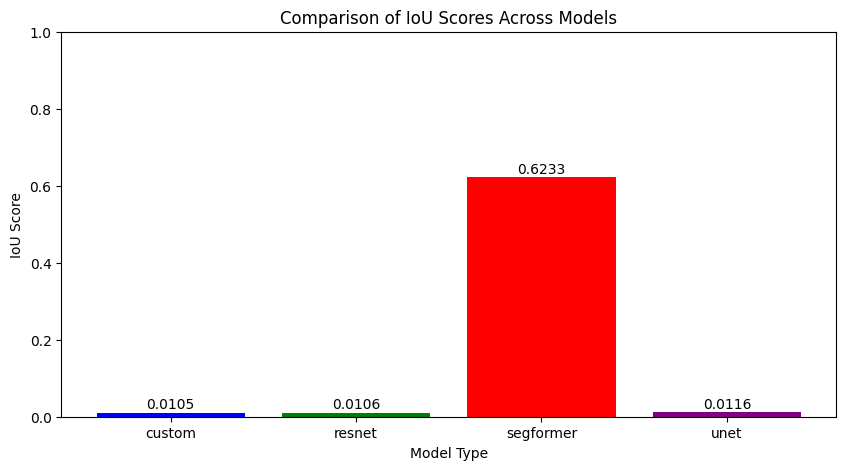

In [150]:
# Visualization
import matplotlib.pyplot as plt

# Extract model names and IoU scores for plotting
model_names = list(model_results.keys())
iou_scores = list(model_results.values())

# Plot the IoU scores
plt.figure(figsize=(10, 5))
plt.bar(model_names, iou_scores, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model Type')
plt.ylabel('IoU Score')
plt.title('Comparison of IoU Scores Across Models')
plt.ylim(0, 1)  # IoU scores range from 0 to 1
for i, score in enumerate(iou_scores):
    plt.text(i, score + 0.01, f"{score:.4f}", ha='center')
plt.show()

In [151]:
best_models = {}
for model_type, checkpoint_path in best_checkpoints.items():
    if checkpoint_path:
        best_models[model_type] = load_model(checkpoint_path, model_type)


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [157]:
# def visualize_segmentation(original_image, ground_truth_mask, predicted_mask, title):
#     fig, axes = plt.subplots(1, 3, figsize=(18, 6))
#     axes = axes.flatten()

#     # If the images are grayscale, ensure the channel dimension is dropped
#     if original_image.ndim == 3 and original_image.shape[0] == 3:  # RGB image
#         original_image = original_image.permute(1, 2, 0)  # Change to (H, W, C) for matplotlib

#     # Original image
#     axes[0].imshow(original_image, cmap='gray')
#     axes[0].set_title('Original Image')
#     axes[0].axis('off')

#     # Ground truth mask
#     axes[1].imshow(ground_truth_mask, cmap='gray')
#     axes[1].set_title('Ground Truth Mask')
#     axes[1].axis('off')

#     # Predicted mask
#     axes[2].imshow(predicted_mask, cmap='gray')
#     axes[2].set_title('Predicted Mask')
#     axes[2].axis('off')

#     plt.suptitle(title)
#     plt.show()


def visualize_segmentation(original_image, ground_truth_mask, predicted_mask, title, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes = axes.flatten()

    if original_image.ndim == 3 and original_image.shape[0] == 3:  # Check for RGB image
        original_image = original_image.permute(1, 2, 0)  # Convert to HWC for matplotlib

    # Original image
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Ground truth mask
    axes[1].imshow(ground_truth_mask, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Predicted mask
    axes[2].imshow(predicted_mask, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.suptitle(title)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()  # Display the figure


In [153]:
test_images, test_masks = next(iter(test_loader))  # Assuming test_loader is already defined


In [154]:
# Check what test_loader returns
for batch in test_loader:
    images, masks = batch['image'], batch['mask']
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")
    break  # Just break after checking the first batch


Image batch shape: torch.Size([3, 3, 128, 128])
Mask batch shape: torch.Size([3, 1, 128, 128])


In [155]:
test_batch = next(iter(test_loader))  # Get a batch from the test_loader
test_images, test_masks = test_batch['image'], test_batch['mask']


./visualizations/custom/segmentation_custom_sample_1.png


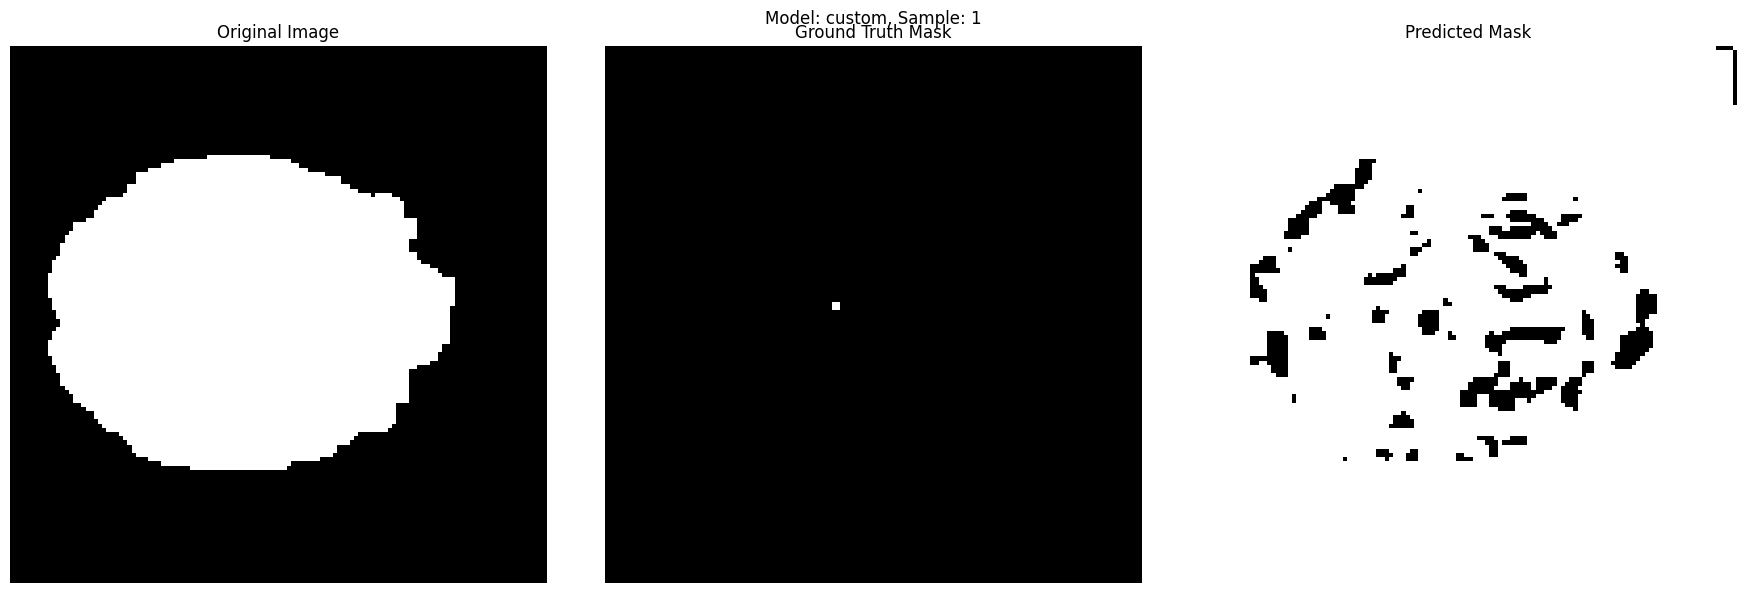

./visualizations/custom/segmentation_custom_sample_2.png


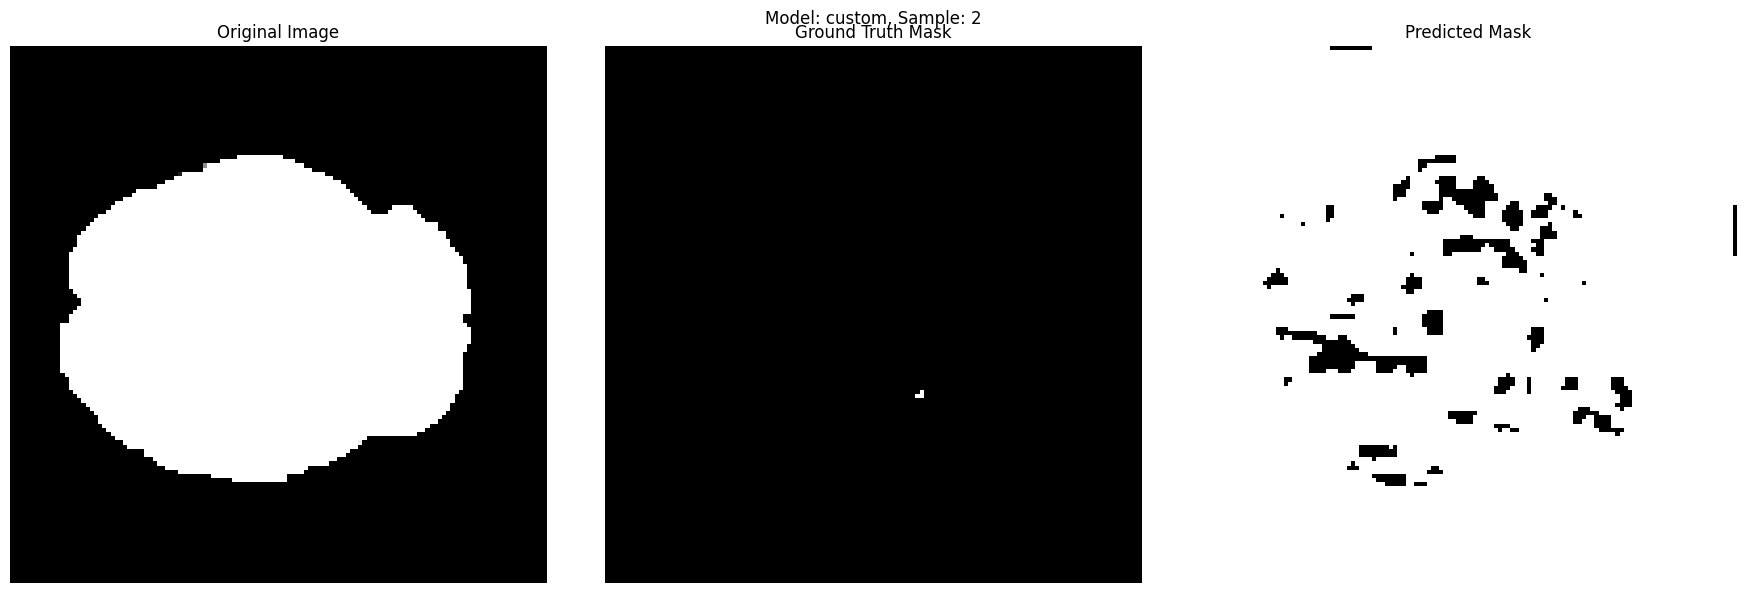

./visualizations/custom/segmentation_custom_sample_3.png


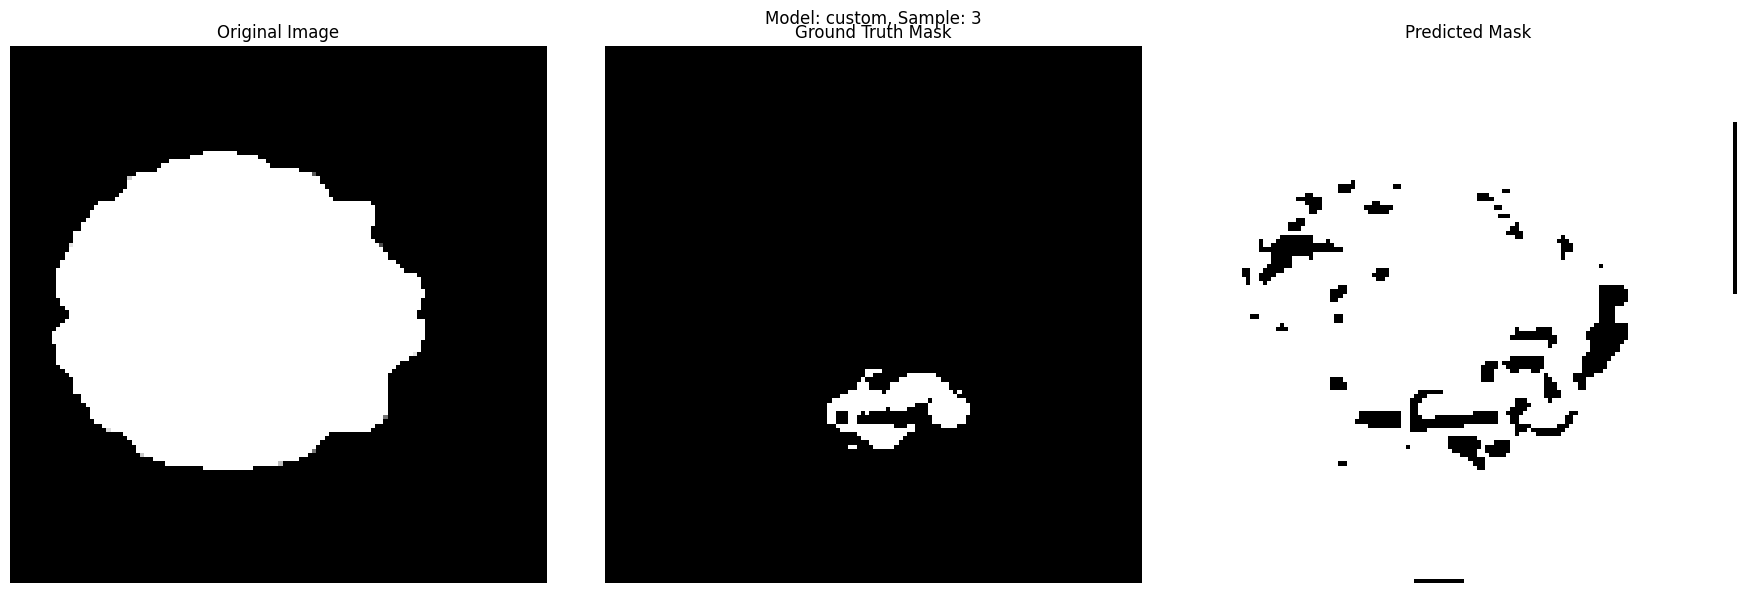

./visualizations/resnet/segmentation_resnet_sample_1.png


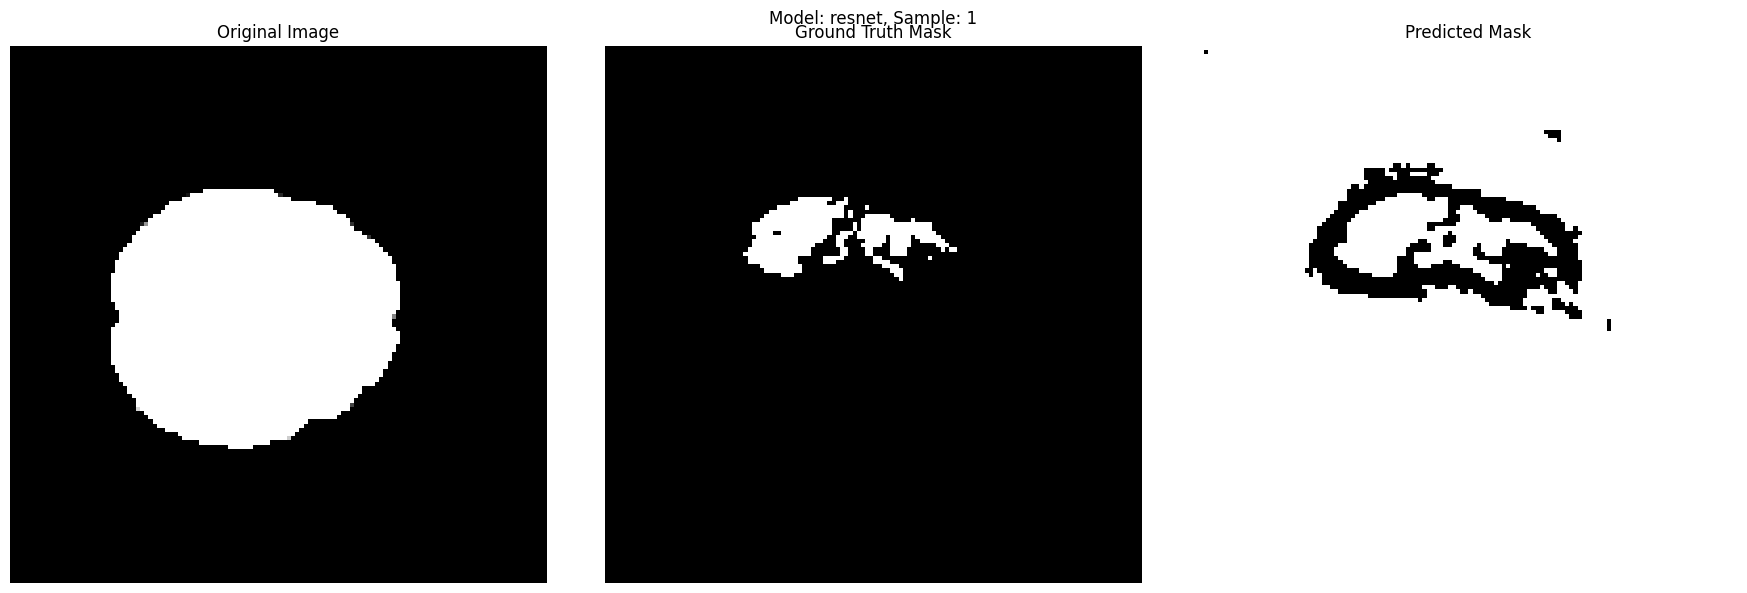

./visualizations/resnet/segmentation_resnet_sample_2.png


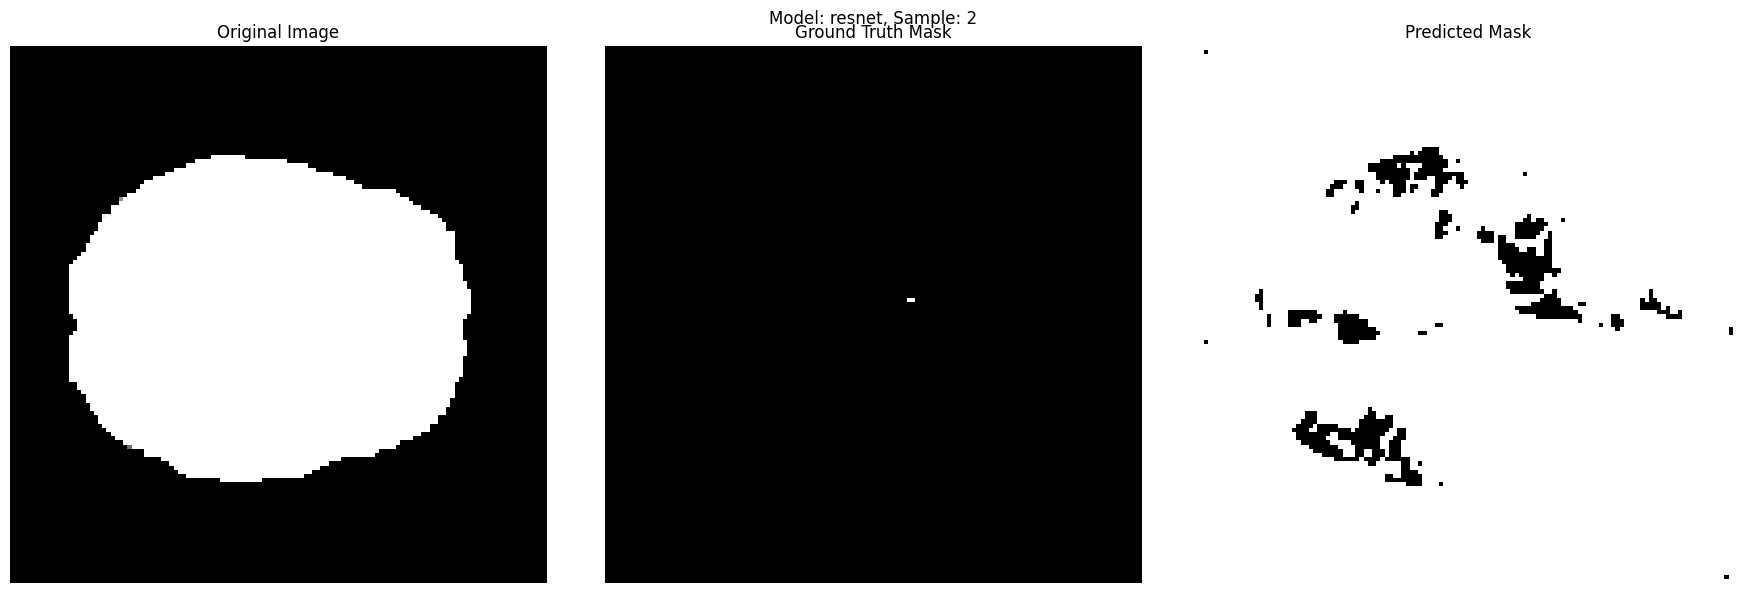

./visualizations/resnet/segmentation_resnet_sample_3.png


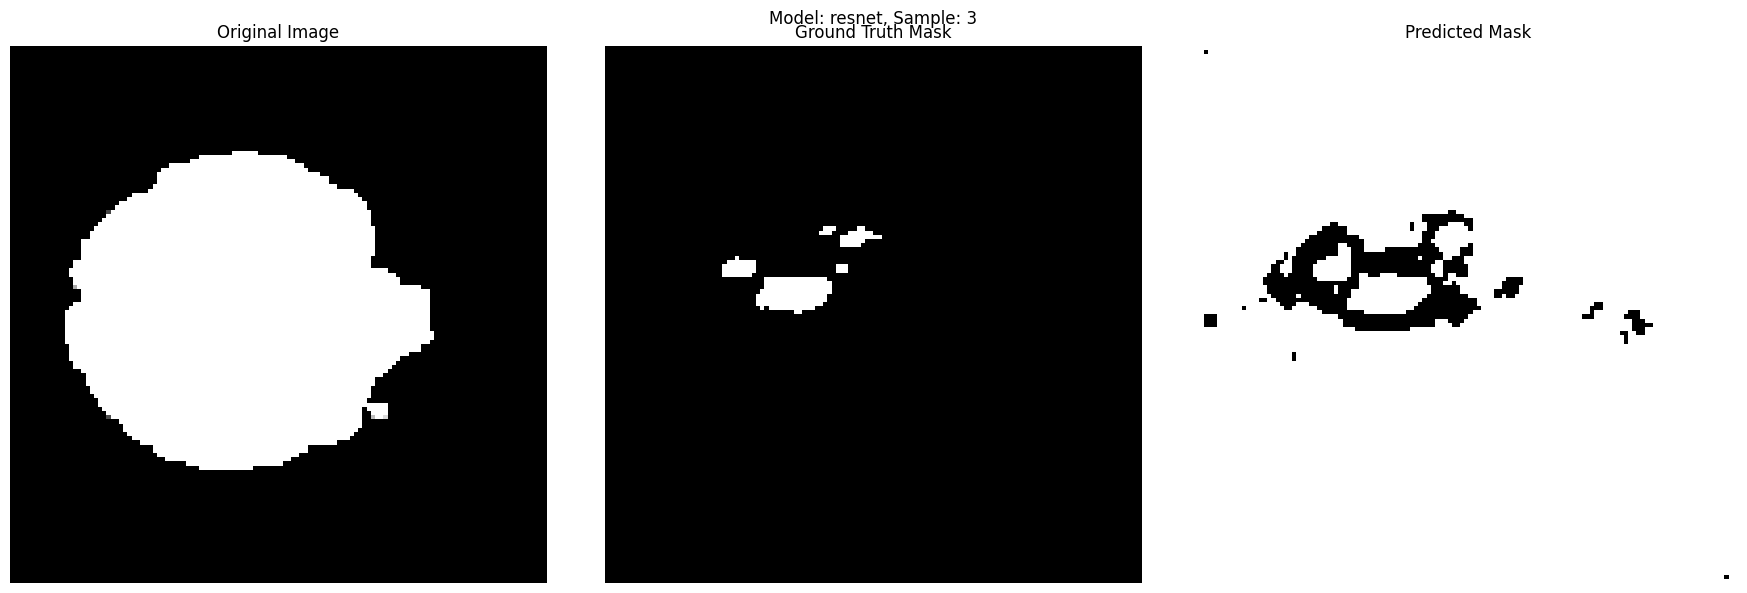

./visualizations/segformer/segmentation_segformer_sample_1.png


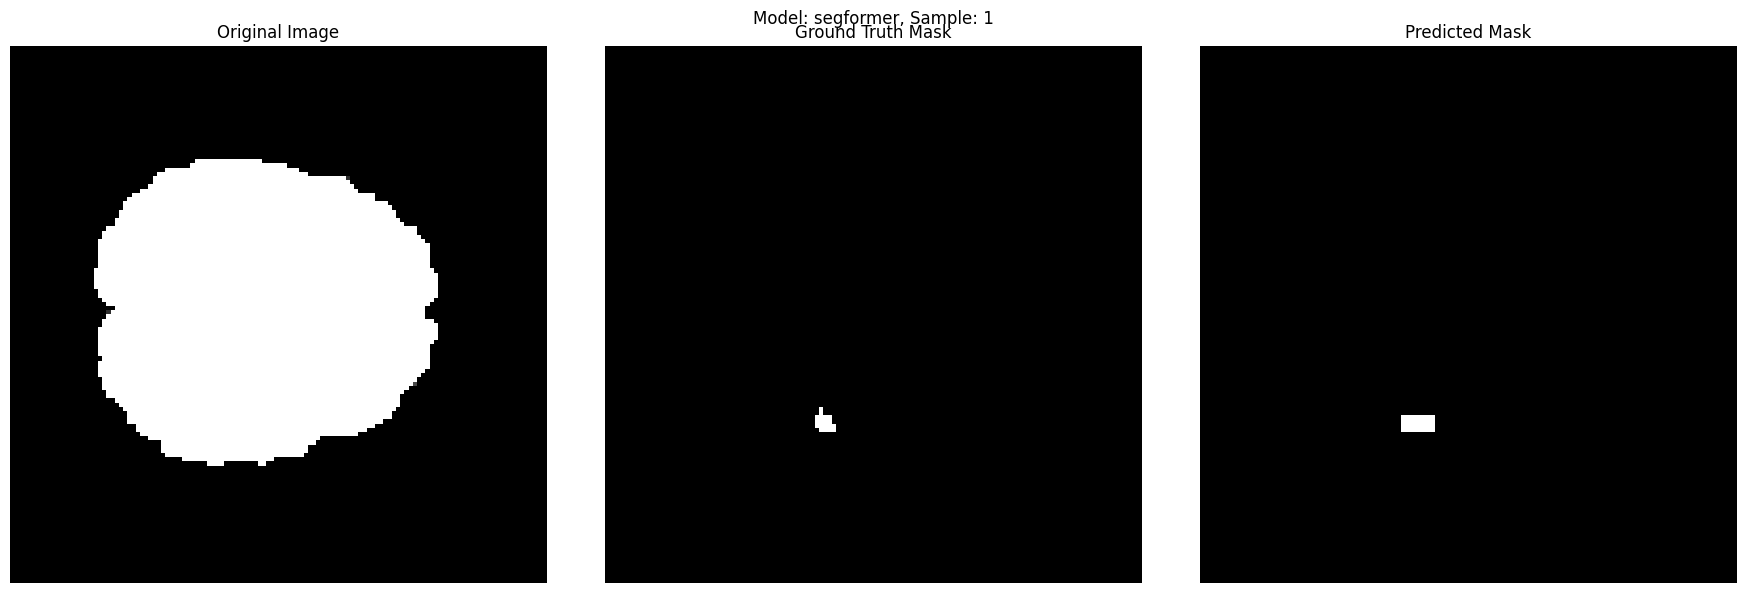

./visualizations/segformer/segmentation_segformer_sample_2.png


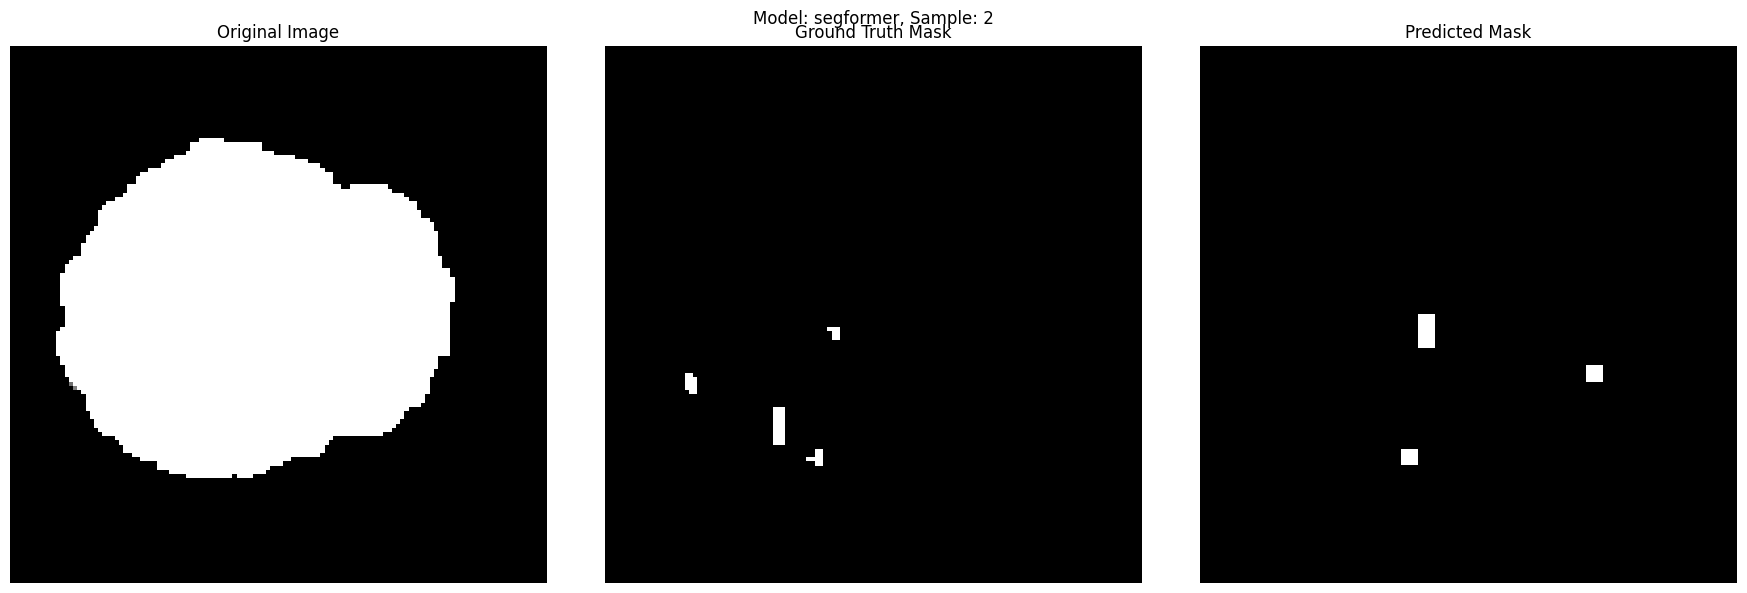

./visualizations/segformer/segmentation_segformer_sample_3.png


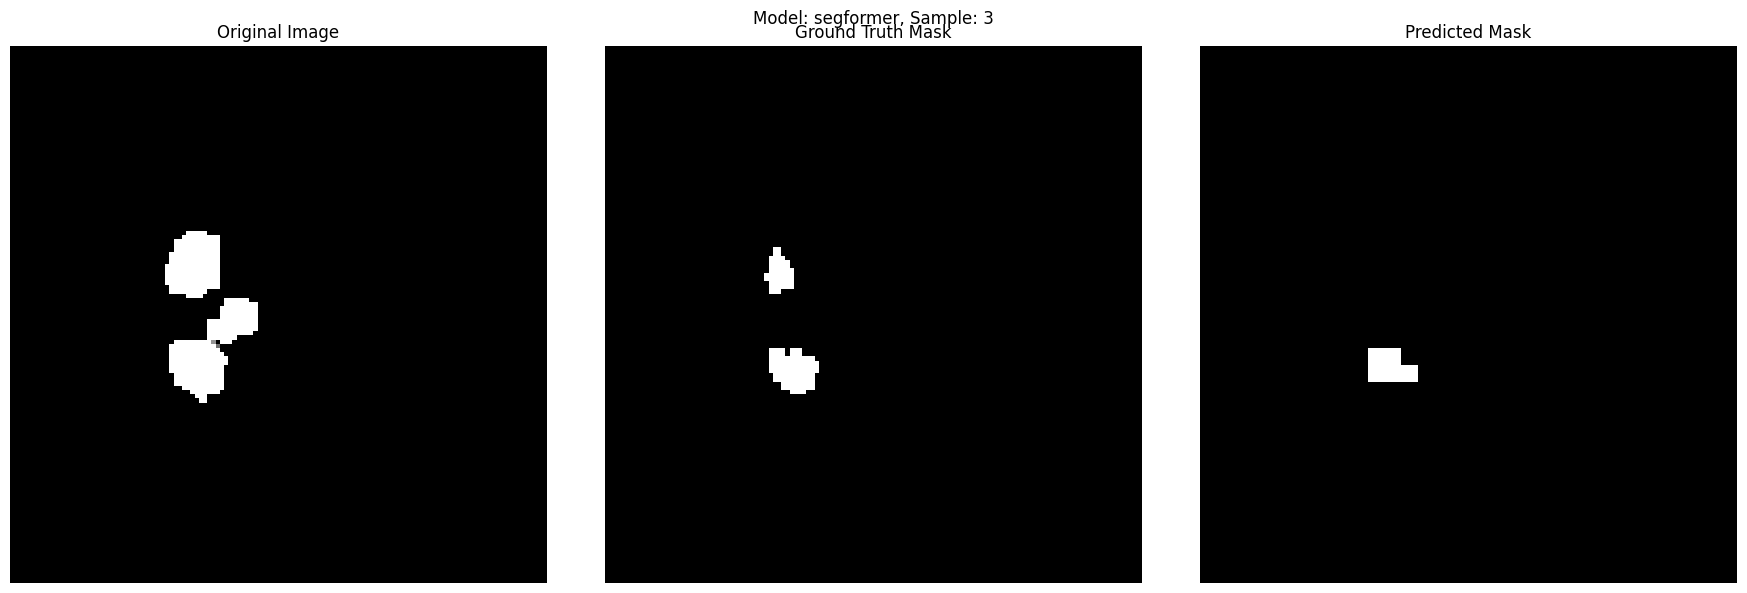

./visualizations/unet/segmentation_unet_sample_1.png


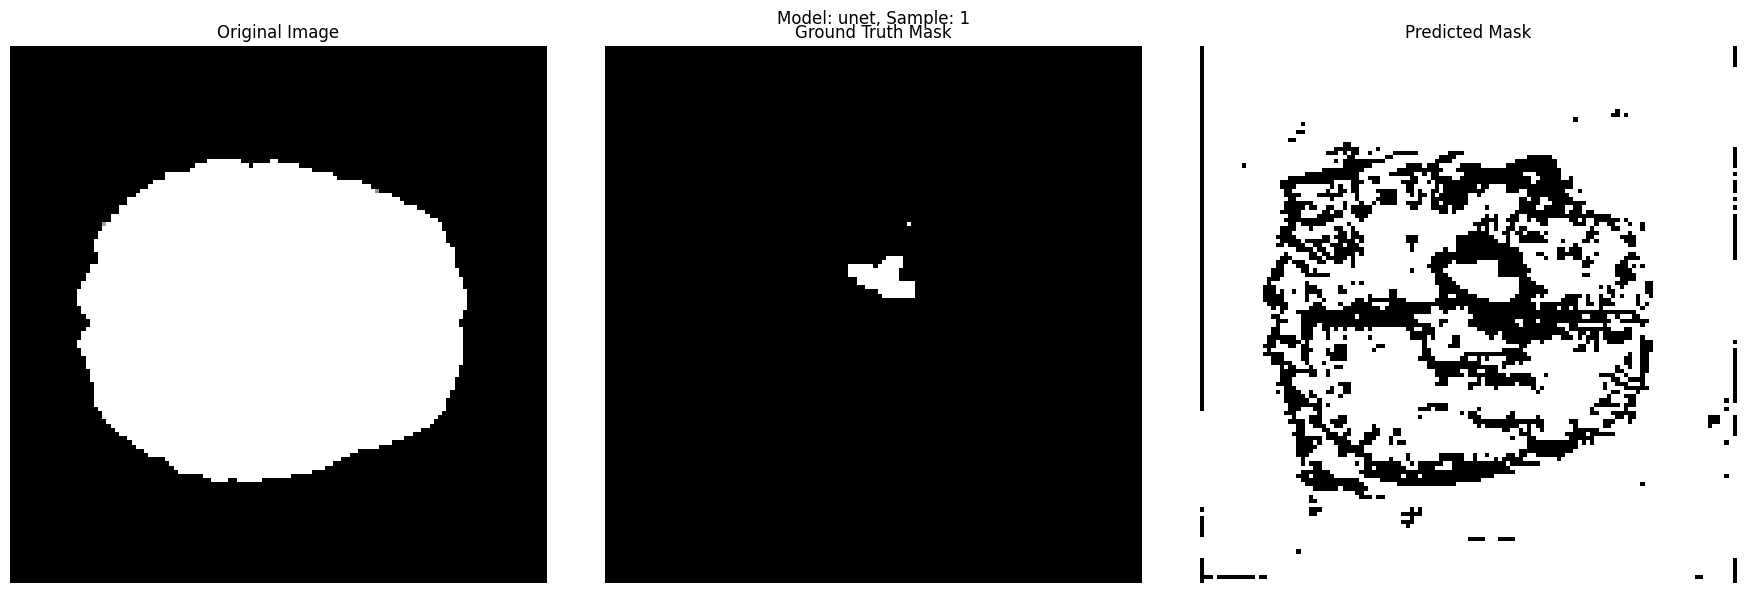

./visualizations/unet/segmentation_unet_sample_2.png


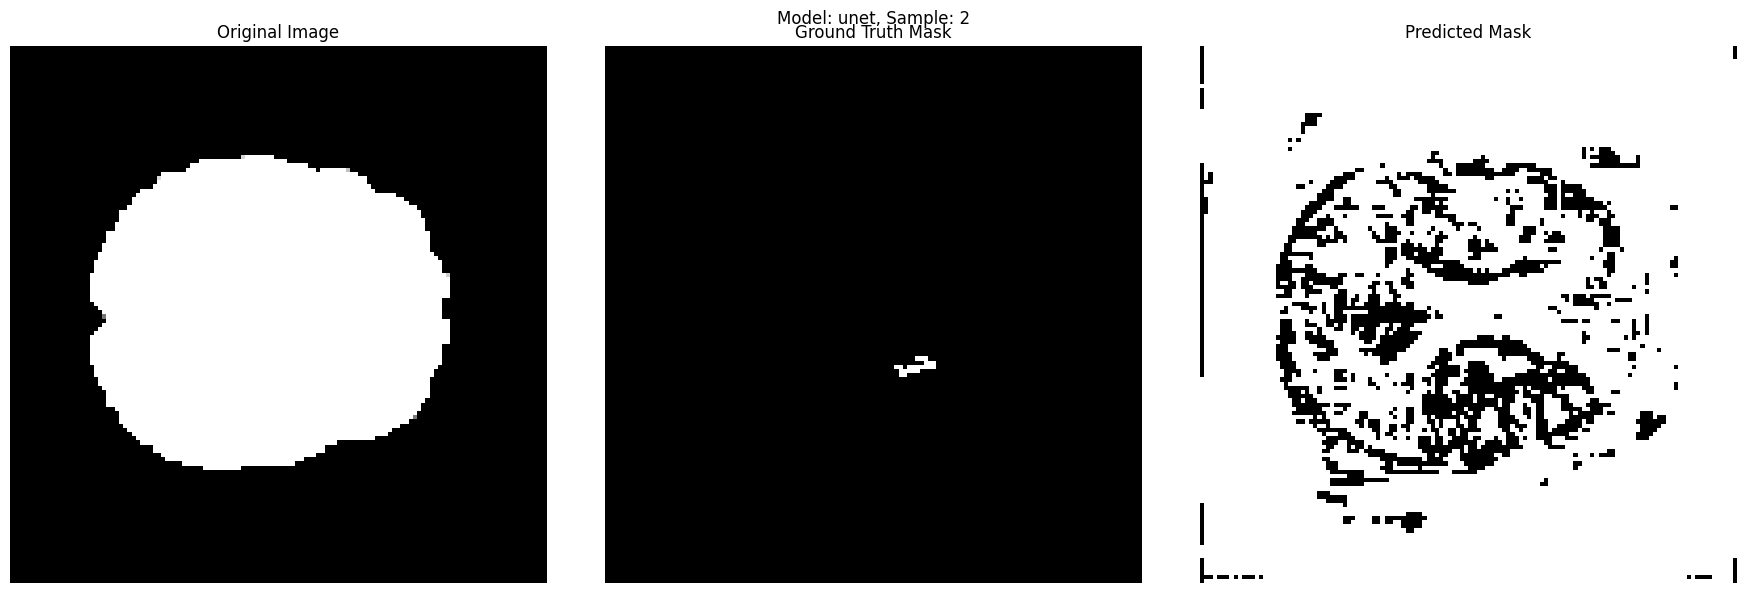

./visualizations/unet/segmentation_unet_sample_3.png


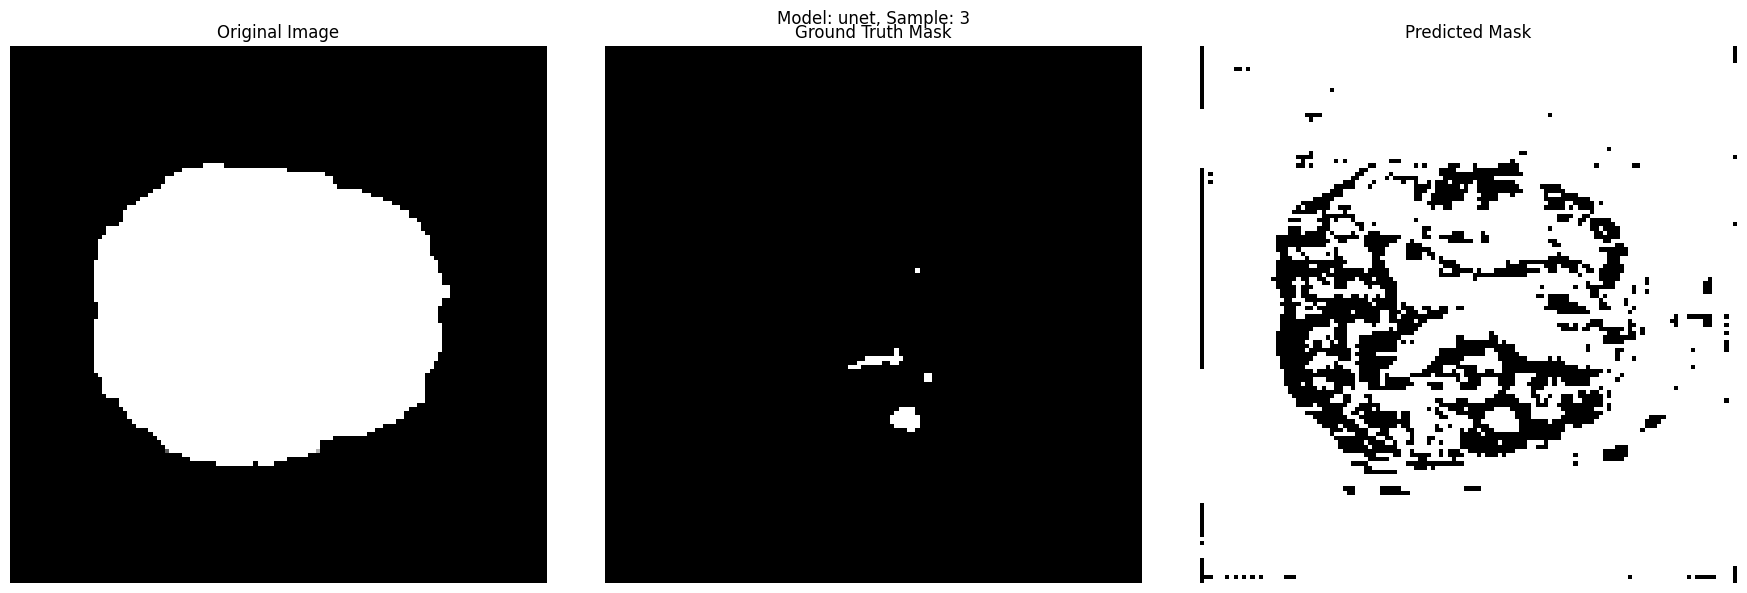

In [160]:
# for model_type, model in best_models.items():
#     model.eval()  # Set the model to evaluation mode

#     # Get a batch of images
#     test_batch = next(iter(test_loader))
#     test_images, test_masks = test_batch['image'], test_batch['mask']
#     test_images, test_masks = test_images.to(device), test_masks.to(device)

#     # Get predictions
#     with torch.no_grad():
#         output = model(test_images)
#         predictions = output if isinstance(output, torch.Tensor) else output['logits']
#         predictions = torch.sigmoid(predictions) > 0.5  # Binarize predictions
#         predictions_np = predictions.cpu().numpy()

#     # Determine number of images to visualize (up to batch size)
#     num_images_to_visualize = min(test_images.size(0), 3)

#     # Visualize the results for each test image in the batch
#     for i in range(num_images_to_visualize):
#         original_image = test_images[i].cpu().squeeze()  # Remove batch dimension
#         ground_truth_mask = test_masks[i].cpu().squeeze()
#         predicted_mask = predictions_np[i].squeeze()

#         # Ensure correct dimensions before visualizing
#         if original_image.ndim == 3 and original_image.shape[0] == 3:  # Check for RGB image with channel-first
#             original_image = original_image.permute(1, 2, 0)  # Convert to HWC for matplotlib

#         visualize_segmentation(
#             original_image.numpy(),
#             ground_truth_mask.numpy(),
#             predicted_mask,
#             title=f"Model: {model_type}, Sample: {i+1}"
#         )
import os

save_dir = './visualizations'
for model_type, model in best_models.items():
    model.eval()

    # Get a batch of images
    test_batch = next(iter(test_loader))
    test_images, test_masks = test_batch['image'], test_batch['mask']
    test_images, test_masks = test_images.to(device), test_masks.to(device)

    # Get predictions
    with torch.no_grad():
        output = model(test_images)
        predictions = output if isinstance(output, torch.Tensor) else output['logits']
        predictions = torch.sigmoid(predictions) > 0.5  # Binarize predictions
        predictions_np = predictions.cpu().numpy()

    # Determine number of images to visualize (up to batch size)
    num_images_to_visualize = min(test_images.size(0), 3)

    # Create a directory to save the visualizations for the current model
    model_save_dir = os.path.join(save_dir, model_type)
    os.makedirs(model_save_dir, exist_ok=True)

    # Visualize the results for each test image in the batch
    for i in range(num_images_to_visualize):
        original_image = test_images[i].cpu().squeeze()  # Remove batch dimension
        ground_truth_mask = test_masks[i].cpu().squeeze()
        predicted_mask = predictions_np[i].squeeze()

        # Ensure correct dimensions before visualizing
        if original_image.ndim == 3 and original_image.shape[0] == 3:  # Check for RGB image with channel-first
            original_image = original_image.permute(1, 2, 0)  # Convert to HWC for matplotlib

        # Define the save path for the visualized image
        save_path = os.path.join(model_save_dir, f'segmentation_{model_type}_sample_{i+1}.png')
        print(save_path)

        visualize_segmentation(
            original_image.numpy(),
            ground_truth_mask.numpy(),
            predicted_mask,
            title=f"Model: {model_type}, Sample: {i+1}",
            save_path=save_path
        )
